In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import product
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns

def read_csv(folder_path, dataset_name, reduction_mode):
    if reduction_mode:
        csv_files = [f for f in os.listdir(folder_path) if (dataset_name in f and reduction_mode in f and 'all' not in f)]
    else:
        csv_files = [f for f in os.listdir(folder_path) if (dataset_name in f and 'all' not in f)]
    df_list = []
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df_list.append(df)

    df_combined = pd.concat(df_list, ignore_index=True)
    return df_combined

In [3]:
def aggregate_metrics(df_combined, method):
    if method == 'knn':
        columns = ['K', 'Distance', 'Voting scheme', 'Weight scheme']
    elif method == 'svm':
        columns = ['Kernel']
    
    grouped_df = df_combined.groupby(columns)

    # Compute mean and standard deviation of the relevant metrics
    metrics_summary = grouped_df.agg({
        'Accuracy': ['mean', 'std'],
        'Precision_Class_0': ['mean', 'std'],
        'Recall_Class_0': ['mean', 'std'],
        'F1_Class_0': ['mean', 'std'],
        'Precision_Class_1': ['mean', 'std'],
        'Recall_Class_1': ['mean', 'std'],
        'F1_Class_1': ['mean', 'std'],
        'Solving Time': ['mean', 'std']
    }).reset_index()


    # Rename the columns for clarity
    metrics_summary.columns = columns + [
                            'Accuracy_mean', 'Accuracy_std',
                            'Precision_Class_0_mean', 'Precision_Class_0_std',
                            'Recall_Class_0_mean', 'Recall_Class_0_std',
                            'F1_Class_0_mean', 'F1_Class_0_std',
                            'Precision_Class_1_mean', 'Precision_Class_1_std',
                            'Recall_Class_1_mean', 'Recall_Class_1_std',
                            'F1_Class_1_mean', 'F1_Class_1_std',
                            'Solving Time_mean', 'Solving Time_std']

    metrics_summary = metrics_summary.sort_values(by='Accuracy_mean', ascending = False)

    # Get the best hyperparameters (the first row after sorting)
    best_hyperparams = metrics_summary.iloc[0][columns].to_dict()
    best_accuracy = metrics_summary.iloc[0]['Accuracy_mean']

    # Print the best hyperparameters and their accuracy
    print("Best Hyperparameters:")
    print(best_hyperparams)
    print(f"Best Accuracy: {best_accuracy:.4f}")
    
    return metrics_summary, best_hyperparams


In [125]:
def get_metrics_knn(best_models, df_combined, metric):
    metric_values = []
    for _, row in best_models.iterrows():
        # Store model identification (e.g., hyperparameters)
        model_id = (row['Voting scheme'], row['Weight scheme'], row['Distance'], row['K'])

        # Filter for the current hyperparameter combination
        filtered_df = df_combined[
            (df_combined['Voting scheme'] == row['Voting scheme']) & 
            (df_combined['Weight scheme'] == row['Weight scheme']) &
            (df_combined['Distance'] == row['Distance']) &
            (df_combined['K'] == row['K'])
        ]
        # Collect accuracy values for this combination
        metric_values.append(list(filtered_df[metric].values))
    
    return metric_values

def get_metrics_svm(best_models, df_combined, metric):
    metric_values = []
    for _, row in best_models.iterrows():
        # Store model identification (e.g., hyperparameters)
        model_id = (row['Kernel'])

        # Filter for the current hyperparameter combination
        filtered_df = df_combined[
            (df_combined['Kernel'] == row['Kernel'])
        ]
    # Collect accuracy values for this combination
        metric_values.append(list(filtered_df[metric].values))
    
    return metric_values

In [164]:
from autorank import autorank, plot_stats, create_report

def evaluation_test(metric_values, metric, data2):

    # Perform the Friedman test if there are three or more models
    if len(metric_values) >= 3:

        stat, p_value = stats.friedmanchisquare(*metric_values)
        print(f"Friedman test statistic: {stat}, p-value: {p_value}")

        if p_value < 0.05:
            print("Significant differences found, conducting Nemenyi post-hoc test")
            data = pd.DataFrame(metric_values).T  # Transpose so each column is a model
            nemenyi_result = sp.posthoc_nemenyi_friedman(data)
            #print(nemenyi_result)

            results = autorank(data2, alpha = 0.05, order = 'descending')
            try:
                create_report(results)
            except:
                pass
            #print(results)
            # Set up subplots: 2 rows, 1 column
            fig, axs = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [2, 5]})  # Adjust the figsize as needed

            # Plot the autorank results
            plot_stats(results, ax=axs[0])
            axs[0].set_title("Autorank Results")
            # Plot the accuracy values in a violin plot with individual data points
            sns.violinplot(data=data, ax=axs[1], inner=None, palette="pastel", linewidth=1.5)  # Add a color palette and line width
            sns.stripplot(data=data, ax=axs[1], color='black', alpha=0.7, jitter=True, size=3)  # Modify transparency and point size

            # Add gridlines for better readability
            axs[1].grid(True, linestyle='--', alpha=0.7)

            # Improve title and labels
            axs[1].set_title(f"Model {metric} Values", fontsize=16, fontweight='bold')
            axs[1].set_ylabel("Accuracy", fontsize=14)
            axs[1].set_xlabel("Models", fontsize=14)

            # Rotate x-tick labels for better readability (optional)
            axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right', fontsize=12)

            plt.tight_layout()  # Adjust layout to prevent overlap
            plt.show()

            plt.show()
            # Adjust layout to prevent overlap
            plt.tight_layout()
            plt.show()

        else:
            print("No significant differences found between the models.")
    
    # Perform the Friedman test if there are two models
    elif len(metric_values) == 2:

        stat, p_value = stats.wilcoxon(metric_values[0], metric_values[1])
        print(f"Wilcoxon signed-rank test statistic: {stat}, p-value: {p_value}")

        if p_value < 0.05:
            print("Significant difference between the two models.")
        else:
            print("No significant differences found between the two models.")

        data = pd.DataFrame(metric_values).T

    else:
        print("Not enough data to perform the test.")
        return

In [165]:
def evaluation_t_test(metric_values1, metric_values2):

    stat, p_value = stats.ttest_rel(metric_values1, metric_values2)
    print(f"Paired t-test statistic: {stat}, p-value: {p_value}")

    if p_value < 0.05:
        print("Significant difference found between the two models.")
    else:
        print("No significant differences found between the two models.")

Evaluating method knn on dataset: grid
Best Hyperparameters:
{'K': 7, 'Distance': 'minkowski2', 'Voting scheme': 'Majority_class', 'Weight scheme': 'Mutual_classifier'}
Best Accuracy: 0.9672
Evaluating Accuracy
Friedman test statistic: 41.74952561669829, p-value: 2.0604831639016286e-07
Significant differences found, conducting Nemenyi post-hoc test
The statistical analysis was conducted for 7 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population Mj_MC_m2_7 (p=0.002). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the med

C:\Users\xavid\AppData\Local\Temp\ipykernel_26204\2393147547.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right', fontsize=12)


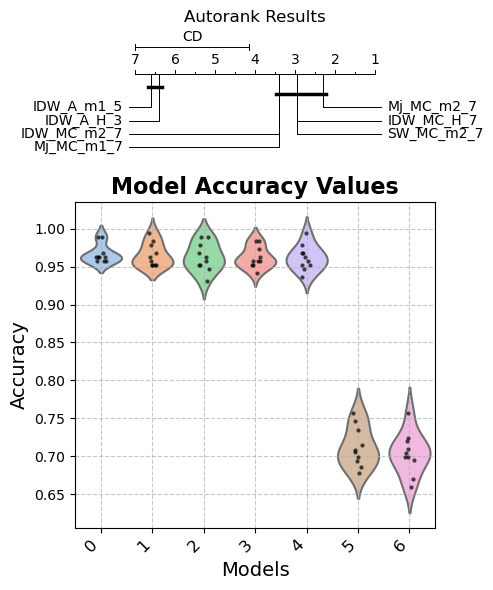

<Figure size 640x480 with 0 Axes>

Evaluating Solving Time
Friedman test statistic: 54.814285714285745, p-value: 5.053497511949795e-10
Significant differences found, conducting Nemenyi post-hoc test
The statistical analysis was conducted for 7 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population IDW_A_H_3 (p=0.001). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean 

C:\Users\xavid\AppData\Local\Temp\ipykernel_26204\2393147547.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right', fontsize=12)


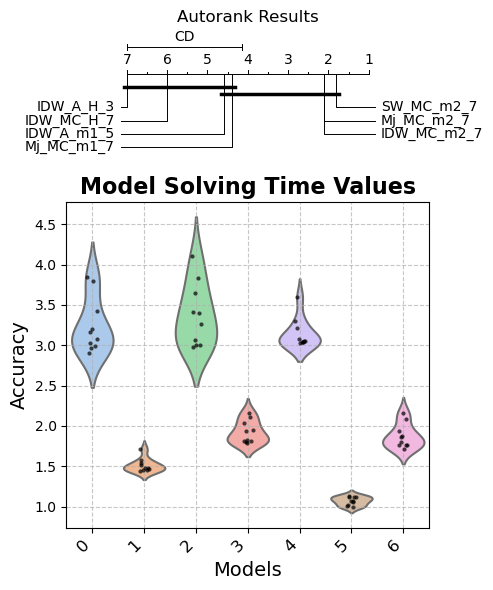

<Figure size 640x480 with 0 Axes>



Evaluating method svm on dataset: grid
Best Hyperparameters:
{'Kernel': 'rbf'}
Best Accuracy: 0.9142
Evaluating Accuracy


KeyError: 'Voting scheme'

In [166]:
#Read_csvs

dataset_names = ['grid','sick']
methods = ['knn','svm']
best_params = {}
metric = 'Accuracy'

votings = {
    'Majority_class': 'Mj',
    'Inverse_Distance_Weights': 'IDW',
    'Sheppards_Work': 'SW'
}
distances = {
    'minkowski1': 'm1',
    'minkowski2': 'm2',
    'HEOM': 'H',    
}
weighting = {
    'Mutual_classifier':'MC',
    'Relief': 'R',
    'ANOVA': 'A'
}

for dataset_name in dataset_names:
    best_params[dataset_name] = {}
    for method in methods:
        print(f'Evaluating method {method} on dataset: {dataset_name}')
        df_combined = read_csv(f'results_{method}', dataset_name, False)
        metrics_summary, best_hyperparams = aggregate_metrics(df_combined, method)
        metrics_summary.to_csv(f'results_{method}/results_{dataset_name}_all.csv', index=False)
        best_params[dataset_name][method] = best_hyperparams

        for metric in ['Accuracy', 'Solving Time']:
            print(f'Evaluating {metric}')


            if method == 'knn':
                best_models = metrics_summary.iloc[[0, 1, 2, 3, 4, 90, 100]]
                metric_values = get_metrics_knn(best_models, df_combined, metric)

            elif method == 'svm':
                best_models = metrics_summary.iloc[[0, 1]]
                metric_values = get_metrics_svm(best_models, df_combined ,metric)
            
            data = pd.DataFrame()
            for el, (i,row) in zip(metric_values, best_models.iterrows()):
                data[f"{votings[row['Voting scheme']]}_{weighting[row['Weight scheme']]}_{distances[row['Distance']]}_{row['K']}"] = el
            evaluation_test(metric_values, metric, data)
            


        print('\n')
    break
 

In [148]:
dataframe_best_results_together = {}

num_samples = {'grid': 1700, 'sick': 3395}

for dataset_name in dataset_names:
    dataframe_best_results_together[dataset_name] = pd.DataFrame()
    for method in methods:
        df_combined = read_csv(f'results_{method}', dataset_name, False)
        metrics_summary, best_hyperparams = aggregate_metrics(df_combined, method)
        
        # Make a copy of the best_models DataFrame to avoid SettingWithCopyWarning
        best_models = metrics_summary.head(5).copy()
        
        if method == 'knn':
            metric_values = get_metrics_knn(best_models, df_combined)[0]
        elif method == 'svm':
            metric_values = get_metrics_svm(best_models, df_combined)[0]
        
        best_models.loc[:, 'Method'] = method
        best_models.loc[:, 'Num samples'] = num_samples[dataset_name]
        dataframe_best_results_together[dataset_name] = pd.concat((dataframe_best_results_together[dataset_name], best_models.head(1)))
        
        for reduction in ['CNN', 'DROP', 'EENTh']:

            print(f'\nComparing method {method} on dataset {dataset_name} with reduction {reduction}')
            results_reduced = read_csv(f'results_{method}_reduced', dataset_name, reduction)
            metrics_summary, best_hyperparams = aggregate_metrics(results_reduced, method)
            
            # Make a copy of the best_models DataFrame to avoid SettingWithCopyWarning
            best_models = metrics_summary.head(5).copy()
            
            best_models.loc[:, 'Method'] = method
            best_models.loc[:, 'reduction'] = reduction
            best_models.loc[:, 'Num samples'] = results_reduced['Num samples']
            
            dataframe_best_results_together[dataset_name] = pd.concat((dataframe_best_results_together[dataset_name], best_models.head(1)))
            
            metrics_summary.to_csv(f'results_{method}_reduced/results_{dataset_name}_{reduction}_all.csv', index=False)
            metric_values_reduced = results_reduced['Accuracy'].values
            
            evaluation_t_test(metric_values, metric_values_reduced)

Best Hyperparameters:
{'K': 7, 'Distance': 'minkowski2', 'Voting scheme': 'Majority_class', 'Weight scheme': 'Mutual_classifier'}
Best Accuracy: 0.9672


TypeError: get_metrics_knn() missing 1 required positional argument: 'metric'

In [46]:
columns = ['Accuracy_mean', 'Num samples', 'Solving Time_mean', 'reduction', 'Method'] 
dataframe_best_results_together['grid'][columns]

,Accuracy_mean,Num samples,Solving Time_mean,reduction,Method
103,0.967162,1700,3.240735,NaN,knn
0,0.616602,130,0.365052,CNN,knn
0,0.929545,341,0.843815,DROP,knn
0,0.971910,1552,3.357328,EENTh,knn
0,0.914167,1700,0.284618,NaN,svm
0,0.854294,130,0.011683,CNN,svm
0,0.889282,341,0.017874,DROP,svm
0,0.914696,1552,0.160981,EENTh,svm


- is it necessary to do a nemenyi if when doing the friedman pvalue is higher tan 0.05?
Lower the alpha to get more significant differences or include a bad and intermediate solution.

- can we use a library for the tests?
Yes.

- result plots?
No hay preferencia, segun hilo argumental.
Depende de como explicamos los resultados.

- metodologia profundament o no
Nada excepto particular.

- anova f-value com a weighting?


In [ ]:


-